In [8]:
import cv2 as cv
import numpy as np

import matplotlib.pyplot as plt

from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Convolution2D,Flatten,Dense,Dropout,MaxPooling2D,Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
data = np.load('Preprocessed_data.npy')
imgs = data[0]
steering = data[1]

#splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(imgs, steering, test_size= 0.2)

In [3]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(18271,)
(4568,)
(18271,)
(4568,)


### Image Processing, Batch generator and Image Augmentation

In [4]:
#refer to Image Processing notebook for more details
#about this cell

#Now combining the brigtness control and
#image fliping in one function
#this function of augmentation is also going to
#be a batch generator

def batch_generator(imgs,steering,batch_size):
    
    #infinite loop
    while True:
        
        X=[]
        y=[]
        
        #running the whole process for each batch of images
        for i in range(batch_size):
        
            #getting random image index from imgs
            index = np.random.randint(0,len(imgs)-1)
            #passing and reading the random image index
            img = cv.imread(imgs[index])
            
            #converting the image to yuv as discussed above
            img = cv.cvtColor(img, cv.COLOR_BGR2YUV)
            #or img = bgr2yuv(img)
            
            #cropping image as discussed above
            img = img[60:135,:,:]
            #or img = crop_img(img)
            
            #adjusting for the model's first layer  with size (66,200,3) as input
            img = cv.resize(img, (200,66))
            
            #instead of going for each image brigntness control
            #we will go for only random images
            if (np.random.rand()>0.5):
                #brightness control
                brigtness_cont = np.random.randint(1,4)
                img = (img/ brigtness_cont).astype(np.uint8)

            #similarly for fliping the image
            if (np.random.rand()>0.5):
                #image fliping
                img = cv.flip(img,1)
                steering_angle = -float(steering[index])
            else:
                steering_angle = float(steering[index])

            X.append(img)
            # y.append(steering_angle)
            y.append(float(steering[index]))
        
        #converting the image 
        # and steering_angle processed into the numpy array
        X = np.array(X)
        y = np.array(y)
        
        
        #Yield is a keyword in Python that is used to return from a function 
        #without destroying the states of its local variable and
        #when the function is called, the execution starts from the last yield statement. 
        #Any function that contains a yield keyword is termed a generator. 
        #Hence, yield is what makes a generator. 
        yield X,y

In [14]:
model = Sequential()

model.add(Lambda(lambda x : x/127.5 - 1.0, input_shape=(66,200,3)))
model.add(Convolution2D(32, (3,3), strides = (2,2), activation = 'elu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(Convolution2D(64, (3,3), activation='elu', strides = (2,2)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Convolution2D(128, (3,3),activation='elu',strides=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'mse')

In [15]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_5 (Lambda)           (None, 66, 200, 3)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 99, 32)        896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 49, 32)       0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 16, 49, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 24, 64)         18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 3, 12, 64)        0         
 2D)                                                  

In [20]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('min_loss_model_vgg_100.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')

In [21]:
#taking len(X_train)//64 = 36 images for steps for each epoch 
history = model.fit(batch_generator(X_train,y_train,64), steps_per_epoch = 300, epochs = 50, callbacks = [mc],
                    validation_data = batch_generator(X_test,y_test,64), validation_steps = 200)

Epoch 1/50
300/300 [==============================] - 323s 1s/step - loss: 0.0202 - val_loss: 0.0183
Epoch 2/50
300/300 [==============================] - 104s 349ms/step - loss: 0.0203 - val_loss: 0.0183
Epoch 3/50
300/300 [==============================] - 44s 148ms/step - loss: 0.0204 - val_loss: 0.0184
Epoch 4/50
300/300 [==============================] - 33s 111ms/step - loss: 0.0204 - val_loss: 0.0187
Epoch 5/50
300/300 [==============================] - 28s 93ms/step - loss: 0.0207 - val_loss: 0.0189
Epoch 6/50
300/300 [==============================] - 26s 88ms/step - loss: 0.0199 - val_loss: 0.0181
Epoch 7/50
300/300 [==============================] - 26s 86ms/step - loss: 0.0199 - val_loss: 0.0187
Epoch 8/50
300/300 [==============================] - 26s 87ms/step - loss: 0.0203 - val_loss: 0.0185
Epoch 9/50
300/300 [==============================] - 26s 87ms/step - loss: 0.0197 - val_loss: 0.0180
Epoch 10/50
300/300 [==============================] - 26s 88ms/step - loss: 0.

In [18]:
# print("The validation accuracy is :", history.history['val_accuracy'])
# print("The training accuracy is :", history.history['accuracy'])
print("The validation loss is :", history.history['val_loss'])
print("The training loss is :", history.history['loss'])

The validation loss is : [0.04011804983019829, 0.036759134382009506, 0.03433549031615257, 0.03302076458930969, 0.030520321801304817, 0.028256839141249657, 0.026973053812980652, 0.026137618348002434, 0.02461564540863037, 0.025487584993243217, 0.02474462054669857, 0.024312343448400497, 0.023497845977544785, 0.022968199104070663, 0.023527154698967934, 0.022948723286390305, 0.022659599781036377, 0.021920960396528244, 0.021947842091321945, 0.022019609808921814, 0.021317293867468834, 0.02131405659019947, 0.020335931330919266, 0.02157408930361271, 0.020741550251841545, 0.021247602999210358, 0.02110132947564125, 0.020386602729558945, 0.020137954503297806, 0.020143166184425354, 0.019970035180449486, 0.019154878333210945, 0.019595041871070862, 0.01972021907567978, 0.01914028637111187, 0.019346296787261963, 0.019369637593626976, 0.01927957683801651, 0.01884882152080536, 0.019267447292804718, 0.01891893893480301, 0.018768617883324623, 0.01842655800282955, 0.018692564219236374, 0.01905713602900505,

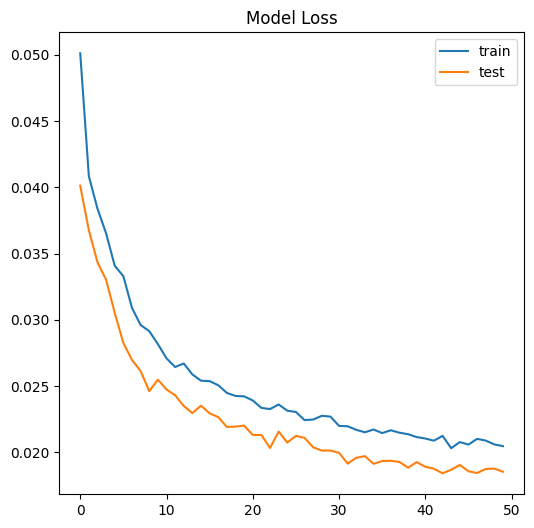

In [19]:
plt.figure(figsize = (6,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Model Loss")
plt.show()

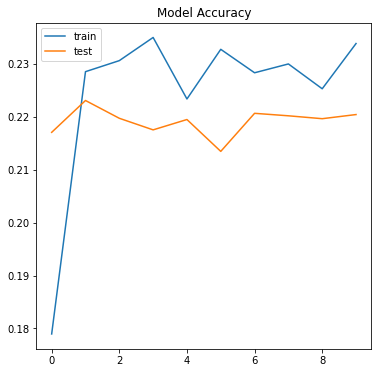

In [31]:
plt.figure(figsize = (6,6))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.title("Model Accuracy")
plt.show()

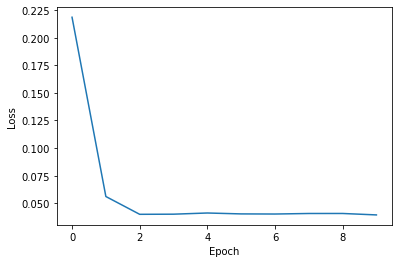

In [21]:
plt.plot(history.history['loss'])

plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.show()

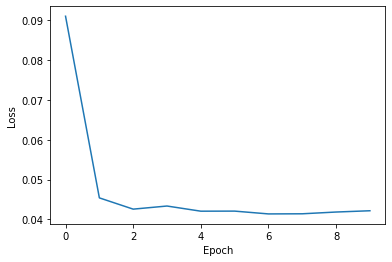

In [22]:
plt.plot(history.history['val_loss'])

plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.show()

In [23]:
model.save('Model.h5')